# 3.1 Linear Regression

- Regression
  - the task of predicting a real valued target $y$ given a data point $x$.

## 3.1.1 Basic Elements of Linear Regression
- Prediction can be expressed as a *linear* combination of the input features.
- Linear Model 
  - Example: estimating the price of a house
$$\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b$$
  - General Form
    - In the case of $d$ variables $$\hat{y} = w_1 \cdot x_1 + ... + w_d \cdot x_d + b$$<br/>$$\hat{y} = \mathbf{w}^\top \mathbf{x} + b$$<br/>
    - We'll try to find the weight vector $w$ and bias term $b$ that approximately associate data points $x_i$ with their corresponding labels $y_i$.
    - For a collection of data points $\mathbf{X}$ the predictions $\hat{\mathbf{y}}$ can be expressed via the matrix-vector product $${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b$$

      - ***Model parameters***: $\mathbf{w}$, $b$

- Training Data
  - ‘features’ or 'covariates'
    - The two factors used to predict the label 
  - $n$: the number of samples that we collect. 
  - Each sample (indexed as $i$) is described by $x^{(i)} = [x_1^{(i)}, x_2^{(i)}]$, and the label is $y^{(i)}$.

- Loss Function
  - Square Loss for a data sample $$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2,$$

    - the smaller the error, the closer the predicted price is to the actual price
  - To measure the quality of a model on the entire dataset, we can simply average the losses on the training set.$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$
  - In model training, we want to find a set of model parameters, represented by $\mathbf{w}^*$, $b^*$, that can minimize the average loss of training samples: $$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\ L(\mathbf{w}, b).$$
  
- Optimization Algorithm
  - ***The mini-batch stochastic gradient descent***
    - In each iteration, we randomly and uniformly sample a mini-batch $\mathcal{B}$ consisting of a fixed number of training data samples.
    - We then compute the derivative (gradient) of the average loss on the mini batch the with regard to the model parameters.
    - This result is used to change the parameters in the direction of the minimum of the loss.$$ \begin{aligned} \mathbf{w} &\leftarrow \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) = \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right) \\b &\leftarrow b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_b l^{(i)}(\mathbf{w}, b) = b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \left(\mathbf{w}^\top \mathbf{x}^{(i)} - y^{(i)}\right). \end{aligned} $$
      - $|\mathcal{B}|$: the number of samples (batch size) in each mini-batch
      - $\eta$: learning rate
     
    - hyper-parameters
      - $|\mathcal{B}|$, $\eta$
      - They are set somewhat manually and are typically not learned through model training. 
    
- Model prediction (or Model inference)

## 3.1.2 From Linear Regression to Deep Networks
- Neural Network Diagram
  -  a neural network diagram to represent the linear regression model 
![](https://github.com/diveintodeeplearning/d2l-en/raw/master/img/singleneuron.svg?sanitize=true)

  - $d$: feature dimension (the number of inputs)
    
- A Detour to Biology
![](https://github.com/diveintodeeplearning/d2l-en/raw/master/img/Neuron.svg?sanitize=true)

  - ***Dendrites***: input terminals
  - ***Nucleus***: CPU
  - ***Axon***: output wire
  - Axon terminals (output terminals) are connected to other neurons via ***synapses***.

- Vectorzation for Speed
  - Vectorizing code is a good way of getting order of mangitude speedups.

In [1]:
from mxnet import nd
from time import time

a = nd.ones(shape=10000)
b = nd.ones(shape=10000)

- 1) add them one coordinate at a time using a for loop.

In [2]:
start = time()
c = nd.zeros(shape=10000)
for i in range(10000):
    c[i] = a[i] + b[i]
print(time() - start)

0.8771929740905762


- 2) add the vectors directly:

In [3]:
start = time() 
d = a + b
print(time() - start)

0.00016832351684570312


## 3.1.3 The Normal Distribution and Squared Loss

- ***Maximum Likelihood Principle***
  - The notion of maximizing the likelihood of the data subject to the parameters
  - its estimators are usually called ***Maximum Likelihood Estimators (MLE)***. 
  - minimize the Negative Log-Likelihood
- <u>The maximum likelihood in a linear model with additive Gaussian noise is equivalent to linear regression with squared loss</u>.

# 3.2 Linear regression implementation from scratch

In [4]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt 
from mxnet import autograd, nd 
import random

## 3.2.1 Generating Data Sets

- The randomly generated batch example feature $\mathbf{X}\in \mathbb{R}^{1000 \times 2}$, 
- The actual weight $\mathbf{w} = [2, -3.4]^\top$ and bias $b = 4.2$ of the linear regression model
- A random noise term $\epsilon$
  - It obeys a normal distribution with a mean of 0 and a standard deviation of 0.01 ($\epsilon \sim \mathcal{N}(0, 0.01^2)$. $$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$$



In [5]:
num_inputs = 2
num_examples = 1000
true_w = nd.array([2, -3.4])
true_b = 4.2

features = nd.random.normal(scale=1, shape=(num_examples, num_inputs)) # scale --> standard deviation

labels = nd.dot(features, true_w) + true_b

labels += nd.random.normal(scale=0.01, shape=labels.shape)

In [6]:
print(features[0])
print(labels[0])


[1.1630787 0.4838046]
<NDArray 2 @cpu(0)>

[4.879625]
<NDArray 1 @cpu(0)>


- By generating a scatter plot using the second features and labels, we can clearly observe the linear correlation between the two.
- For future plotting, we only need to call `gluonbook.set_figsize()` to print the vector diagram and set its size.

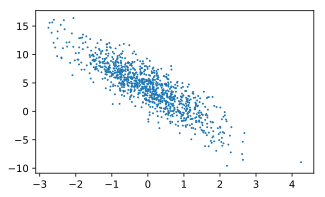

In [7]:
def use_svg_display():
    # Displayed in vector graphics.
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(5, 3)):
    use_svg_display()
    # Set the size of the graph to be plotted.
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), 1);

## 3.2.2 Reading Data

- Here we define a function `data_iter` to return the features and labels of random `batch_size` (batch size) examples.
  - This function has been saved in the `gluonbook` package for future use.

In [30]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # The examples are read at random, in no particular order.
    for i in range(0, num_examples, batch_size):
        j = nd.array(indices[i: min(i + batch_size, num_examples)])
        yield features.take(j), labels.take(j)
        # The “take” function will then return the corresponding element based on the indices.

In [31]:
batch_size = 10
iterator = data_iter(batch_size, features, labels)
X_batch, y_batch = next(iterator)
print(X_batch, y_batch)


[[ 0.5226451  -0.36821297]
 [ 1.4648029  -0.9737964 ]
 [ 0.2238931  -0.22365536]
 [-0.39304093  0.45682105]
 [-0.15107684  0.95578885]
 [-0.1967979  -0.13781767]
 [-0.5158308  -1.1073749 ]
 [ 0.6277698   0.08966792]
 [-1.2582556   1.9790834 ]
 [-0.0842585  -0.73394597]]
<NDArray 10x2 @cpu(0)> 
[ 6.5130043 10.44841    5.4141636  1.867064   0.6560518  4.27661
  6.926715   5.157996  -5.051523   6.529941 ]
<NDArray 10 @cpu(0)>


In [32]:
for X_batch, y_batch in iterator:
    print(X_batch, y_batch)
    break


[[ 2.2771406   0.37218785]
 [-1.4932036   0.13177635]
 [-0.83469146  0.6173635 ]
 [ 0.9580142   0.39661676]
 [-0.6929967   1.6447209 ]
 [ 0.11793987 -2.2566102 ]
 [ 0.28372657 -0.530157  ]
 [-1.1158241   0.2747542 ]
 [-2.1107721   0.04706239]
 [-0.34981632 -0.13172452]]
<NDArray 10x2 @cpu(0)> 
[ 7.4963803   0.7656811   0.44722196  4.7559056  -2.7936707  12.117811
  6.5841184   1.0266986  -0.16563828  3.9547756 ]
<NDArray 10 @cpu(0)>


## 3.2.3 Initialize Model Parameters

- Weights are initialized to normal random numbers using a mean of 0 and a standard deviation of 0.01,
- Bias b is set to zero.

In [33]:
w = nd.random.normal(scale=0.01, shape=(num_inputs, 1))
b = nd.zeros(shape=(1,))

- We’ll update each parameter, w and b, in the direction that reduces the loss.
- In order for `autograd` to know that it needs to set up the appropriate data structures, track changes, etc., we need to attach gradients explicitly.

In [34]:
w.attach_grad()
b.attach_grad()

## 3.2.4 Define the Model

In [35]:
def linreg(X, w, b): 
    return nd.dot(X, w) + b    # return value's shape: (10, 1)

## 3.2.5 Define the Loss Function

In [36]:
def squared_loss(y_hat, y): 
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 3.2.6 Define the Optimization Algorithm

- We’ll solve this problem by stochastic gradient descent `sgd` instead of analytical closed-form solution.
- At each step, we’ll estimate the gradient of the loss with respect to our parameters, using one batch randomly drawn from our dataset.
- Then, we’ll update our parameters a small amount in the direction that reduces the loss.
- Here, the gradient calculated by the automatic differentiation module is the gradient sum of a batch of examples.

In [37]:
def sgd(params, lr, batch_size): 
    for param in params:
        param[:] = param - lr * param.grad / batch_size

## 3.2.7 Training

- Training Procedure
  - Initialize parameters $(\mathbf{w}, b)$
  - Repeat until done
    - Compute loss $l(\mathbf{x}^i, y^i, \mathbf{w}, b)$
    - Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{\mathcal{B}} \sum_{i \in \mathcal{B}} l(\mathbf{x}^i, y^i, \mathbf{w}, b)$
    - Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$
- Loss shape
  - Since we previously set `batch_size` to 10, the loss shape for each small batch is (10, 1).
- Running `l.backward()` will add together the elements in `l` to obtain the new variable, and then calculate the variable model parameters’ gradient.
- `num_epochs` and `lr` are both hyper-parameters and are set to 3 and 0.03, respectively.


In [38]:
lr = 0.03               # learning rate
num_epochs = 3          # number of iterations
net = linreg            # our fancy linear model
loss = squared_loss     # 0.5 (y-y')^2

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)  # minibatch loss in X and y
        l.backward()                   # compute gradient, w.grad and b.grad, on l with respect to [w, b]
        sgd([w, b], lr, batch_size)    # update parameters [w, b] using their gradient
    train_l = loss(net(features, w, b), labels)
    print('epoch {0}, loss {1:.8f}'.format(epoch + 1, float(train_l.mean().asnumpy())))

epoch 1, loss 0.03515049
epoch 2, loss 0.00011977
epoch 3, loss 0.00004835


In [39]:
print('Error in estimating w', true_w - w.reshape(true_w.shape))
print('Error in estimating b', true_b - b)

Error in estimating w 
[2.7418137e-04 3.6954880e-05]
<NDArray 2 @cpu(0)>
Error in estimating b 
[-1.7642975e-05]
<NDArray 1 @cpu(0)>


# 3.3 Gluon Implementation of Linear Regression

## 3.3.1 Generating Data Sets

In [68]:
from mxnet import autograd, nd

num_inputs = 2
num_examples = 1000
true_w = nd.array([2, -3.4])
true_b = 4.2

features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))

labels = nd.dot(features, true_w) + true_b

labels += nd.random.normal(scale=0.01, shape=labels.shape)

## 3.3.2 Reading Data

In [69]:
from mxnet.gluon import data as gdata

batch_size = 10

# Combining the features and labels of the training data. 
dataset = gdata.ArrayDataset(features, labels)

# Randomly reading mini-batches.
data_iter = gdata.DataLoader(dataset, batch_size, shuffle=True)

In [70]:
for X, y in data_iter:
    print(X, y)
    break


[[-1.6311898   0.17929219]
 [-0.60608387  1.2890214 ]
 [ 1.2066218  -0.23281197]
 [-1.6739345  -0.19565606]
 [-0.6975202   0.1806888 ]
 [ 1.3205358  -1.0833067 ]
 [-0.23225537  1.2591201 ]
 [ 1.4396188   1.9778014 ]
 [-2.8449814  -0.765359  ]
 [-0.7729255   0.5642861 ]]
<NDArray 10x2 @cpu(0)> 
[ 0.34095168 -1.3967377   7.4045095   1.5087711   2.2066317  10.523467
 -0.5347519   0.36069041  1.1080252   0.7397361 ]
<NDArray 10 @cpu(0)>


## 3.3.3 Define the Model

- Gluon provides a large number of predefined layers, which allow us to ***focus especially on the layers used to construct the model*** rather than having to focus on the implementation.
- We will first define a model variable `net`
- In Gluon, a `Sequential` instance can be regarded as a container that concatenates the various layers in sequence.
- We need a single layer. 
  - The layer is fully connected since it connects all inputs with all outputs by means of a matrix-vector multiplication. ![](https://github.com/diveintodeeplearning/d2l-en/raw/master/img/singleneuron.svg?sanitize=true)
  - In Gluon, the fully connected layer is referred to as a `Dense` instance. 
  - Since we only want to generate a single scalar output, we set that number to 1.
  - We do not need to specify the input shape for each layer, such as the number of linear regression inputs.
    - When the `net(X)` is executed later, the model will automatically infer the number of inputs in each layer. 

In [71]:
from mxnet.gluon import nn
net = nn.Sequential()
net.add(nn.Dense(1))

## 3.3.4 Initialize Model Parameters

In [72]:
from mxnet import init
net.initialize(init.Normal(sigma=0.01))

- We are initializing parameters for a networks where we haven’t told yet how many dimensions the input will have. 
- The real initialization are deferred until the first time that data is sent through the networks. 
    - Since the parameters have not been initialized yet, we would not be able to manipulate them yet.

## 3.3.5 Define the Loss Function

In [73]:
from mxnet.gluon import loss as gloss
loss = gloss.L2Loss()

## 3.3.6 Define the Optimization Algorithm

In [74]:
from mxnet import gluon
trainer = gluon.Trainer(
    params = net.collect_params(), 
    optimizer = 'sgd', 
    optimizer_params = {
        'learning_rate': 0.03
    }
)

## 3.3.7 Training

- We don’t have to 
  - individually allocate parameters, 
  - define our loss function, 
  - implement stochastic gradient descent.
- We need tell `trainer.step` about the amount of data (i.e., `batch_size`)

In [75]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter: 
        with autograd.record(): 
            l = loss(net(X), y)
        l.backward()
        trainer.step(batch_size)
    train_l = loss(net(features), labels)
    print('epoch {0}, loss {1:.8f}'.format(epoch + 1, float(train_l.mean().asnumpy())))

epoch 1, loss 0.04303914
epoch 2, loss 0.00016977
epoch 3, loss 0.00004908


- We get the layer we need from the net and access its weight (weight) and bias (bias).

In [76]:
w = net[0].weight.data()
print('Error in estimating w', true_w.reshape(w.shape) - w) 

b = net[0].bias.data()
print('Error in estimating b', true_b - b)

Error in estimating w 
[[ 0.00129068 -0.00103784]]
<NDArray 1x2 @cpu(0)>
Error in estimating b 
[0.00063229]
<NDArray 1 @cpu(0)>


# 3.4 Softmax Regression

## 3.4.1 Classification Problems
- The input image has a height and width of 2 pixels and the color is grayscale.
  - We record the four pixels in the image as $x_1, x_2, x_3, x_4$. 
- The actual labels of the images in the training data set are "cat", "chicken" or "dog" 
  - $y$ is viewed as a three-dimensional vector (one hot encoding) via$$y \in {(1, 0, 0), (0, 1, 0), (0, 0, 1)}$$
  - $(1,0,0)$: "cat"
  - $(0,1,0)$: "chicken"
  - $(0,0,1)$: "dog"
  <br/>
- Network Architecture
  - There are 4 features and 3 output animal categories
  $$ \begin{aligned} o_1 &= x_1 w_{11} + x_2 w_{21} + x_3 w_{31} + x_4 w_{41} + b_1,\\ o_2 &= x_1 w_{12} + x_2 w_{22} + x_3 w_{32} + x_4 w_{42} + b_2,\\ o_3 &= x_1 w_{13} + x_2 w_{23} + x_3 w_{33} + x_4 w_{43} + b_3. \end{aligned} $$
  <br/>
  - The neural network diagram below depicts the calculation above.
  ![](https://github.com/diveintodeeplearning/d2l-en/raw/master/img/softmaxreg.svg?sanitize=true)
- Softmax Operation
  - In vector form we arrive at $\mathbf{o} = \mathbf{W} \mathbf{x} + \mathbf{b}$.
  - We can use a simple approach to treat the output value $o_i$ as the ***confidence level*** of the prediction category $i$.
  - The output of softmax regression is subjected to a nonlinearity which ensures that the sum over all outcomes always adds up to 1 and that none of the terms is ever negative. $$ \hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o}) \text{ where } \hat{y}_i = \frac{\exp(o_i)}{\sum_j \exp(o_j)} $$
  - We can still find the most likely class by $$ \hat{\imath}(\mathbf{o}) = \operatorname*{argmax}_i o_i = \operatorname*{argmax}_i \hat y_i $$
  - Summarizing it all in vector notation $${\hat{\mathbf{y}}}^{(i)} = \mathrm{softmax}({\mathbf{o}}^{(i)}) = \mathrm{softmax}(\mathbf{W} {\mathbf{x}}^{(i)} + {\mathbf{b}})$$

- Vectorization for Minibatches
  - Assume that we are given a mini-batch $\mathbf{X}$ of examples with dimensionality $d$ and batch size $n$.
  - Assume that we have q categories (outputs)
  - Then the minibatch features $\mathbf{X}$ are in $\mathbb{R}^{n \times d}$, weights $\mathbf{W} \in \mathbb{R}^{d \times q}$ and the bias satisfies $\mathbf{b} \in \mathbb{R}^q$.

$$ \begin{aligned} \mathbf{O} &= \mathbf{W} \mathbf{X} + \mathbf{b} \\ \hat{\mathbf{Y}} & = \mathrm{softmax}(\mathbf{O}) \end{aligned} $$




## 3.4.2 Loss Function

- Log-Likelihood
  - Softmax function allows us to compare the estimates with reality, simply by checking how well it predicted what we observe. $$ p(Y|X) = \prod_{i=1}^n p(y^{(i)}|x^{(i)}) = \prod_{i=1}^n \prod_{j}( {\hat{y}_j}^{(i)})^{y_{j}^{(i)}} $$
  and thus the Loss Function $L$ (***Log-Likelihood***) $$L = -\log p(Y|X) = \sum_{i=1}^n -\log p(y^{(i)}|x^{(i)}) = - \sum_{i=1}^n \sum_{j} y_{j}^{(i)} log {\hat{y}_j}^{(i)} $$
  [NOTE] $log {\hat{y}_j}^{(i)} \leq 0$, so that $L \geq 0$
  - $L$ is minimized if we correctly predict $y$ with ***certainty***, i.e. ${\hat{y}_j}^{(i)} = 1$ for the correct label.

- Softmax and Derivatives
  - we dropped the superscript $(i)$ to avoid notation clutter<br/><br/>$$ l = -\sum_j y_j \log \hat{y}_j = -\sum_j y_j \log \frac{\exp(o_j)}{\sum_k \exp(o_k)} = \sum_j y_j \log \sum_k \exp(o_k) - \sum_j y_j o_j = \log \sum_k \exp(o_k) - \sum_j y_j o_j $$<br/>
  - consider the the loss function's derivative with respect to $o_j$<br/><br/>$$ \partial_{o_j} l = \frac{\exp(o_j)}{\sum_k \exp(o_k)} - y_j = \mathrm{softmax}(\mathbf{o})_j - y_j = {\hat{y}_j} - y_j $$<br/>
  - Gradient is the difference between the observation $y$ and estimate $\hat{y}$ --> it is very similar to what we saw in regression
    - This fact makes computing gradients a lot easier in practice.
<br/>
- Cross-Entropy Loss
$$ l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_j y_j \log \hat{y}_j $$
  - It is one of the most commonly used ones for multiclass classification.


## 3.4.3 Information Theory Basics
- Entropy
- Kullback Leibler Divergence

## 3.4.4 Model Predictionand Evaluation

- Normally, we use the category with the highest predicted probability as the output category. 
- Accuracy to evaluate the model’s performance. 
  - The ratio between the number of correct predictions and the total number of predictions.